# Makes pie charts of peak distributions
- given a manifest (input norm manifest that the yeolab uses), plots a pie distribution for all rbps

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import cPickle as pickle

In [2]:
ipnorm_manifest = pd.read_table('/projects/ps-yeolab3/bay001/reference_data/ENCODE/ALLDATASETS_submittedonly.txt')
uid2rbp = dict(zip(ipnorm_manifest.uID, ipnorm_manifest.RBP))
ipnorm_manifest.head()

,uID,RBP,Cell line,CLIP_rep1,CLIP_rep2,INPUT
0,203,HNRNPC,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...
1,204,RBFOX2,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...
2,205,IGF2BP1,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...
3,206,HNRNPK,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...
4,209,SRSF7,HepG2,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...,/projects/ps-yeolab3/encode/analysis/encode_v1...


In [3]:
input_dir = '/home/bay001/scratch/'
output_dir = '/home/bay001/scratch/'

In [4]:
l10pv = 5
l2fcv = 3
input_norm_bed_head = ['chrom','start','end','l10p','l2fc','strand','annotation','gene']
# allpeaks = ! ls $wd/*.bed.annotated
# allpeaks[:1]
allpeaks = [
    '/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_FINALforpapers_20180205/hg19/285_01.basedon_285_01.peaks.l2inputnormnew.bed.compressed.bed.annotated',
    '/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_FINALforpapers_20180205/hg19/285_02.basedon_285_02.peaks.l2inputnormnew.bed.compressed.bed.annotated',
    '/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_FINALforpapers_20180205/hg19/215_01.basedon_215_01.peaks.l2inputnormnew.bed.compressed.bed.annotated',
    '/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_FINALforpapers_20180205/hg19/215_02.basedon_215_02.peaks.l2inputnormnew.bed.compressed.bed.annotated'
]

In [5]:
def get_region(row):
    return 'intergenic' if row['annotation'] == 'intergenic' else row['annotation'].split('|')[0]
def get_containment(row):
    return 'intergenic' if row['annotation'] == 'intergenic' else row['annotation'].split('|')[1]

In [6]:
for peak in allpeaks:
    df = pd.read_table(peak,names=input_norm_bed_head)
    name = uid2rbp[re.findall('([\w\d_]+)_[\d].$',os.path.basename(peak).split('.')[0])[0]]
    df['region'] = df.apply(get_region,axis=1)
    df['containment'] = df.apply(get_containment,axis=1)
    dfx = df[(df['l10p'] > l10pv) & (df['l2fc'] > l2fcv)]
    num_peaks = dfx.shape[0]

    regions = dfx['region'].value_counts().to_dict()
    labels = []
    sizes = []

    colors = sns.color_palette("hls", len(regions))

    for region, count in regions.iteritems():
        labels.append(region)
        sizes.append(count)

    """
    Plot pie
    """
    # The slices will be ordered and plotted counter-clockwise.

    plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.title(name,y=1.1)
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, os.path.basename(peak).replace('.annotated','.svg')))
    
    plt.close()
    

# Make 'background' pie charts of transcriptomic and genomic regions
- i just take these from an existing pickle file that gabe generated earlier. too lazy to re-calculate the avg cds/utr esp if they're all the same per annotation

In [7]:
pickle_file = '/projects/ps-yeolab3/encode/analysis/encode_master/204_01_RBFOX2.merged.r2.peaks.bed.clip_analysis.pickle'
pickle = pd.read_pickle(pickle_file)

In [8]:
# actually these are the same values, they should be since the genome backround is the same!
genomic = pd.DataFrame(pickle['genic_region_sizes'], index=['sizes']).T

# reorder the rows so that the colors match
genomic = genomic.loc[['cds','five_prime_utrs','three_prime_utrs','proxintron500','distintron500']]

# Plot the genomic background

(-1.1061731447675971,
 1.1002939592746475,
 -1.1048846473762608,
 1.1049149877270947)

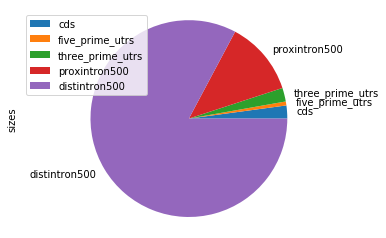

In [9]:
fig, ax = plt.subplots()
genomic.plot(kind='pie', ax=ax, y='sizes')
ax.axis('equal')

# Plot the transcriptomic background

(-1.1072439130455725,
 1.1003449482402654,
 -1.1279847930723974,
 1.1272151386784091)

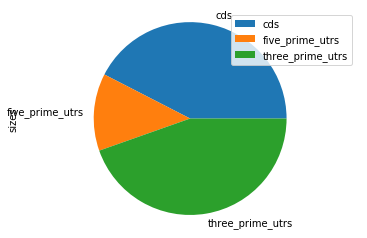

In [10]:
exonic = genomic.copy()
exonic.drop('distintron500', inplace=True, axis=0)
exonic.drop('proxintron500', inplace=True, axis=0)

fig, ax = plt.subplots()
exonic.plot(kind='pie', ax=ax, y='sizes')
ax.axis('equal')